# Quadratic Plot toy

We consider data generated according to the following process. 
A latent variable $ x_0 $ is first sampled uniformly from the interval $[-1, 1]$. The corresponding noiseless target is defined as
    $$y_0 = -x_0^2 + 1.$$
Observed samples $(x, y)$ are then obtained by adding independent Gaussian noise:
    $$x \sim \mathcal{N}(x_0, \sigma^2), 
    \qquad 
    y \sim \mathcal{N}(y_0, \sigma^2),
    \qquad
    z = (x,y)$$
where $\sigma > 0$ controls the level of observational noise.

## Imports and Seeds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import torch
import random
from torch.utils.data import Dataset, DataLoader # to delete later
from scipy.stats import wasserstein_distance
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
seed = 42
# Python built-in RNG
random.seed(seed)
# NumPy RNG
np.random.seed(seed)

# PyTorch RNG (CPU + CUDA)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# For reproducibility in cuDNN backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
mode = "training"
dataset = "swissroll"
N = 500000

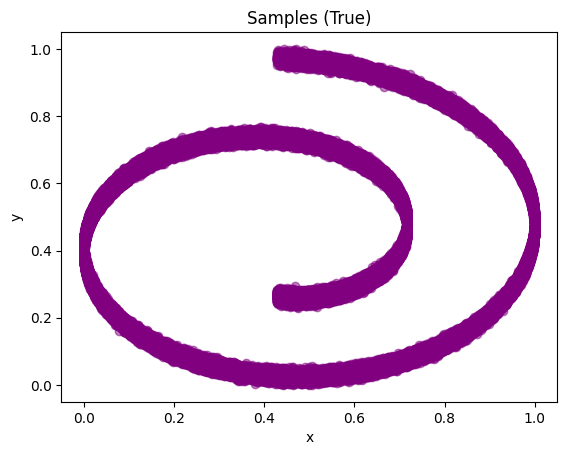

Training data has shape torch.Size([500000, 2, 1, 1]) and type torch.float64 with min x 0.0 max 1.0


In [4]:
if dataset == "quad":
    x_0 = np.random.uniform(low = -1, high = 1, size = (N, ))
    y_0 = - x_0**2 + 1
    x_0 = (x_0 + 1)/2
    z_0 = np.stack((x_0, y_0), axis = 1)

elif dataset == "mnist":
    mnist = MNIST(root='.', download=True, transform=transforms.ToTensor())
    img, _ = mnist[7]     # choose digit "7"
    img = img.squeeze().numpy()

    ys, xs = np.where(img > 0.2)  # pick high-intensity pixels
    idx = np.random.choice(len(xs), size=50000, replace=True)
    x_0 = xs[idx] / img.shape[1]
    y_0 = 1 - ys[idx] / img.shape[0]
    z_0 = np.stack((x_0, y_0), axis=1)

elif dataset == "sphere":
    theta = np.random.uniform(0, 2 * np.pi, N)
    # unit circle coordinates in [-1, 1]
    x = np.cos(theta)
    y = np.sin(theta)

    # optional: normalize to [0, 1] for image-style coordinates
    x_0 = (x + 1) / 2
    y_0 = (y + 1) / 2

    z_0 = np.stack((x_0, y_0), axis=1)

elif dataset == "swissroll":
    # Swiss roll parameters
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(N))   # angle term
    x = t * np.cos(t)
    y = t * np.sin(t)

    # optional vertical offset or noise
    y += 0.2 * np.random.randn(N)

    # normalize to [0, 1] for image-like consistency
    x_0 = (x - x.min()) / (x.max() - x.min())
    y_0 = (y - y.min()) / (y.max() - y.min())

    z_0 = np.stack((x_0, y_0), axis=1)

# plot samples
color = "purple" 
plt.scatter(x_0, y_0, color=color, alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Samples (True)")
plt.show()

training_data = torch.tensor(z_0).unsqueeze(-1).unsqueeze(-1) # images are normalized from 0 to 1

print(f"Training data has shape {training_data.shape} and type {training_data.dtype} with min x {training_data[:,0,:,:].min().item()} max {training_data[:,0,:,:].max().item()}")

torch.save(training_data, f"training_data_{N}_{dataset}.pt")

## 

In [5]:
model = Unet(
    dim = 64,
    dim_mults=(1,),
    flash_attn = True,
    channels = 2,          
    out_dim = 2
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 1,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 1000,    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
    objective = 'pred_noise'
).cuda()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [6]:
train_num_steps = 1000

if mode == "training":

    trainer = Trainer(
        diffusion,
        f'training_data_{N}_{dataset}.pt',
        is_image = False,
        train_batch_size = 500,
        train_lr = 8e-5,
        train_num_steps = train_num_steps,         # total training steps
        gradient_accumulate_every = 2,    # gradient accumulation steps
        ema_decay = 0.995,                # exponential moving average decay
        amp = True,                       # turn on mixed precision
        calculate_fid = False              # whether to calculate fid during training
    )

    trainer.train()
    torch.save(model.state_dict(), f'model_final_{train_num_steps}_{dataset}.pt')

elif mode == "sampling":

    model.load_state_dict(torch.load(f'model_final_{train_num_steps}_{dataset}.pt', map_location='cpu'))

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/n/home00/zoewu/.conda/envs/lightweight_tester/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

training complete


In [7]:
def plot_and_wass(riemann, total_samples = 50000):
    x_wass = []
    y_wass = []

    # keep sampling until you have 1000 total points
    while len(x_wass) < total_samples:
        print(f"Samples {len(x_wass)} out of {total_samples}")
        sampled_images = diffusion.sample(batch_size=1000, riemann=riemann)
        sampled_plotting = sampled_images.squeeze(-1).squeeze(-1)  # [bs, 2]
        x = sampled_plotting[:, 0].cpu().numpy()
        y = sampled_plotting[:, 1].cpu().numpy()

        # extend lists
        x_wass.extend(x)
        y_wass.extend(y)

    # convert to numpy arrays
    x_wass = np.array(x_wass[:1000])
    y_wass = np.array(y_wass[:1000])

    # # Wasserstein distance (assuming x_0, y_0 are defined)
    # x_wass_dist = wasserstein_distance(x_0, x_wass)
    # y_wass_dist = wasserstein_distance(y_0, y_wass)

    # print(f"x Wasserstein: {x_wass_dist:.4f}")
    # print(f"y Wasserstein: {y_wass_dist:.4f}")

    # plot samples
    color = "orange" if riemann else "blue"
    plt.scatter(x_wass, y_wass, color=color, alpha=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Samples ({'Riemann' if riemann else 'Vanilla'})")
    plt.show()

Samples 0 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 1000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 2000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 3000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 4000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 5000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 6000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 7000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 8000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 9000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 10000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 11000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 12000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 13000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 14000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 15000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 16000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 17000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 18000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 19000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 20000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 21000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 22000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 23000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 24000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 25000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 26000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 27000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 28000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 29000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 30000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 31000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 32000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 33000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 34000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 35000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 36000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 37000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 38000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 39000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 40000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 41000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 42000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 43000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 44000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 45000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 46000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 47000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 48000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 49000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

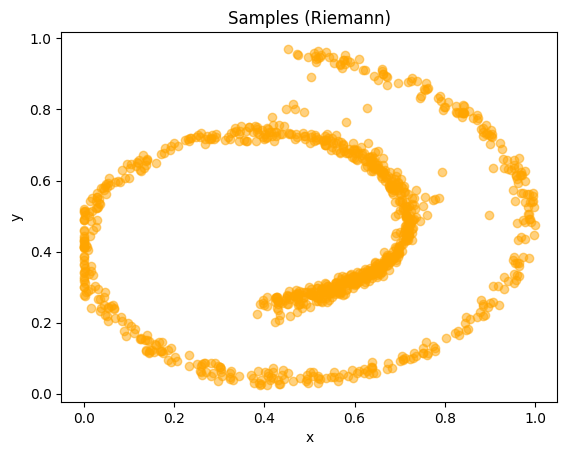

In [8]:
plot_and_wass(True)

Samples 0 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 1000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 2000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 3000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 4000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 5000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 6000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 7000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 8000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 9000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 10000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 11000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 12000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 13000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 14000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 15000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 16000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 17000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 18000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 19000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 20000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 21000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 22000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 23000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 24000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 25000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 26000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 27000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 28000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 29000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 30000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 31000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 32000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 33000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 34000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 35000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 36000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 37000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 38000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 39000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 40000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 41000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 42000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 43000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 44000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 45000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 46000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 47000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 48000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples 49000 out of 50000


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

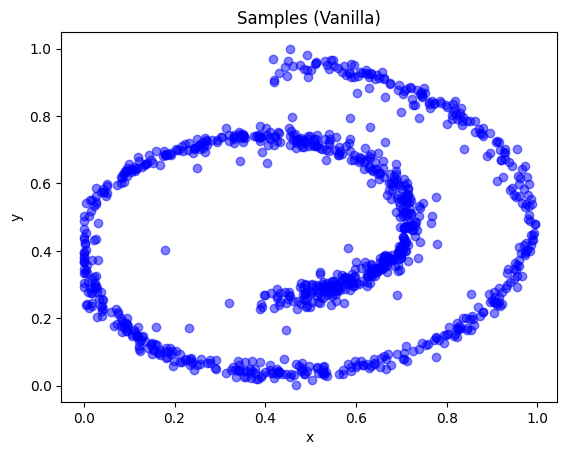

In [9]:
plot_and_wass(False)